Checking agreement between space charge models in synergia and theoretical calculation of beam in a drift.
Two SC models: 2D Hockney, Bassetti-Erskine
Two beam distributions: KV, Gaussian (longitudinal distribution uniform in z and zero energy spread for both cases)

**Particle number convention**

1. The current, I, of interest is that of the beam (not average current)
2. The beam consists of N particles with charge $Q = N e$ (Z = 1 for protons/electrons)
2. Assume beam has length l, velocity $\beta$c, and particles are uniformly distributed
3. The current is then: $I = \frac{Q \beta c}{l}$, and the corresponding number needed is $N = \frac{I l}{\beta c e}$
4. The number of particles per unit length is $\frac{N}{l} = \frac{I}{\beta c e}$ 

**Calculated values and comparison**

With this method, I calculated a proton number scaling of $2.85769 \times 10^8 \frac{p}{m \cdot mA}$, which at 14 mA equates to $4.000763434 \times 10^{9}$ protons per meter.
This corresponds to $5.01 \times 10^{10}$ protons for a completely filled ring (at 4.3 mA), in good agreement with the numbers provided to me by Sasha. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
import tables
from mpi4py import MPI

sys.path.append('/home/vagrant/jupyter/beamsim/synergia/') 
sys.path.append('/home/vagrant/jupyter/hall/space_charge_p5/') 

In [3]:
from base_diagnostics import utils
from base_diagnostics import StandardBeam6D
from base_diagnostics import read_bunch
from base_diagnostics import workflow
from base_diagnostics import lfplot
from base_diagnostics import latticework
from base_diagnostics import basic_calcs
from base_diagnostics import pltbunch
from base_diagnostics import elliptic_sp
from base_diagnostics import singleparticle
from base_diagnostics import options
from gaussian import Gaussian6D
import synergia
import synergia_workflow

##Test problem - Expanding beam in a drift

Benchmarking Parameters:

- 10 m drift (define actively - no need for MADX lattice)

Beam Parameters:

- 14 mA, 2.5 MeV proton beam
- RMS x and y = 1 mm, emittance = 0.3 mm-mrad normalized, KV distribution
- 10 ppc
- 64x64x32 mesh (2D Open)
- 5 turns at 10 m drift length
- Bunch length  equal to drift length (10 m)

In [4]:
#load options for SC_test
from SC_test_options import opts

comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

In [5]:
#Construct the lattice
ol = 1. #10m drift
nsteps_per_element = 100 #1cm steps
o = synergia.lattice.Lattice_element("drift", "o")
o.set_double_attribute("l", ol)

lattice = synergia.lattice.Lattice("test", synergia.lattice.Mad8_adaptor_map())
# Add copies of the lattice elements to the fodo lattice
lattice.append(o)

# Define reference particle to be a proton at 2.5 MeV
total_energy = synergia.foundation.pconstants.proton_mass + 2.5e-3 # 2.5 MeV KE
four_momentum = synergia.foundation.Four_momentum(synergia.foundation.pconstants.proton_mass, total_energy)
reference_particle = synergia.foundation.Reference_particle(synergia.foundation.pconstants.proton_charge,
                                        four_momentum)
opts.gamma = reference_particle.get_gamma()
opts.beta = reference_particle.get_beta()
lattice.set_reference_particle(reference_particle)

#force these for test run
gridx = 64
gridy = 64
gridz = 32
grid = [gridx, gridy, gridz]
opts.gridx = gridx
opts.gridy = gridy
opts.gridz = gridz

n_ppc = 10 #n_ppc particles per transverse cell
n_macro = 100000 #used for 2dhockney: n_ppc*opts.gridx*opts.gridy*opts.gridz
opts.macro_particles = n_macro
outputdir = 'SC_drift_test'
opts.output_dir = outputdir
opts.relpath = opts.output_dir
workflow.make_path(outputdir)

opts.comm_divide = 4
if opts.comm_divide:
    sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
else:
    sc_comm = synergia.utils.Commxx(True)

#sc_comm = synergia.utils.Commxx(True)
if opts.solver == "2dopen-hockney":
    coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
elif opts.solver == "2dbassetti-erskine":
    coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()

#
map_order = 1
opts.steps_per_element = nsteps_per_element
stepper = synergia.simulation.Split_operator_stepper_elements(lattice, map_order, coll_operator, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

print coll_operator

opts.lattice = lattice
opts.lattice_simulator = lattice_simulator

In [6]:
#Cleanup any files from previous runs
try:
    os.remove('myKVBunch.txt')
except OSError:
    pass

files = os.listdir(outputdir)
for file in files:
    if file.endswith('.h5'):
        os.remove(os.path.join(outputdir,file))

files = os.listdir('.')
for file in files:
    if file.endswith('.h5'):
        os.remove(os.path.join('.',file))


##Construct the bunch

In [7]:
current = 14.e-3 #mA of current 
rp_perlength = current/(opts.beta*scipy.constants.c*scipy.constants.e)
bunch_length = 1. #effective bunch length 2 mm
real_particles = rp_perlength*bunch_length

opts.emit_n = 6e-7 #We want 0.3 mm-mrad normalized emittance
opts.emits = [basic_calcs.calc_geometric_emittance(opts.emit_n,opts.beta,opts.gamma)] #give this geometric emittance
dpop = 0.0
opts.real_particles = rp_perlength*bunch_length
opts.betae = 0.5 #statically fix beta
opts.alphae = 0.0

bunchDistribution = "KV"

if bunchDistribution == "KV":
    opts.macro_particles = n_macro
    particles = StandardBeam6D.toyKVBeam6D(opts)
    bunch = particles[0]
elif bunchDistribution == "GaussianInternal": #Not working properly
    opts.macro_particles = n_macro
    particles = Gaussian6D.GaussianBeam6D(opts)
    bunch = particles[0]
elif bunchDistribution == "GaussianElegant":
    bunch = np.loadtxt("gaussian/myGaussianBunch.txt")
    
bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p

#Particle ID 4 is showing odd behavior, so fix that specifically
bunch[4] = bunch[100]
bunch[4,6] = 4.0


np.savetxt('myKVBunch.txt',bunch)         #write the bunch to a text file

In [8]:
#Check emittance
emit = np.sqrt(np.average(bunch[:,0]**2) * np.average(bunch[:,1]**2) - np.average(bunch[:,0]*bunch[:,1])**2)
print "geometric emittance: %s \nnormalized emittance: %s" % (emit, emit * (opts.beta * opts.gamma))

geometric emittance: 4.10849449506e-06 
normalized emittance: 3.00118261251e-07


In [9]:
#read in the bunch
particles_file = 'myKVBunch.txt'
bucket_length = bunch_length #set equal
comm = synergia.utils.Commxx(True) #define a communicator
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

Loading Synergia particles from txt file:  myKVBunch.txt
Read  100000  particles


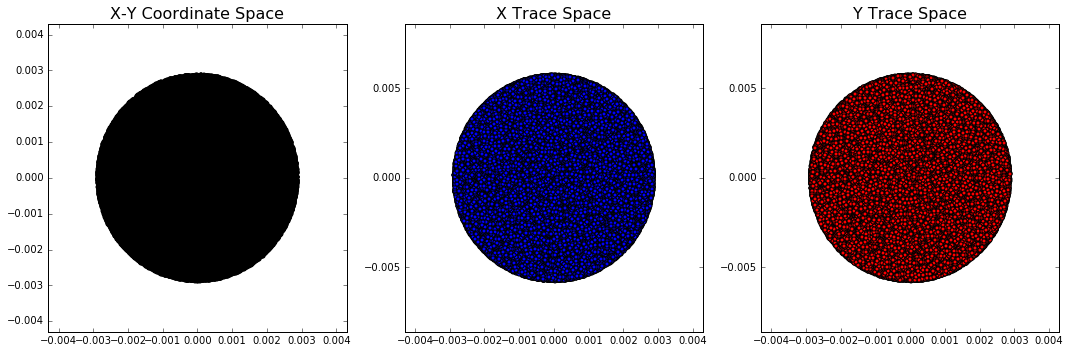

/home/vagrant/.pyenv/versions/2.7.10/lib/python2.7/site-packages/matplotlib/axes/_base.py:3025: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=-0.0
  'bottom=%s, top=%s') % (bottom, top))


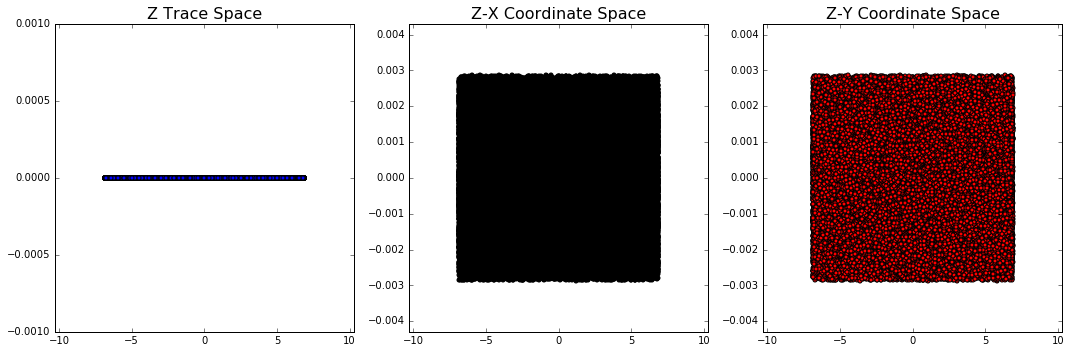

In [10]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

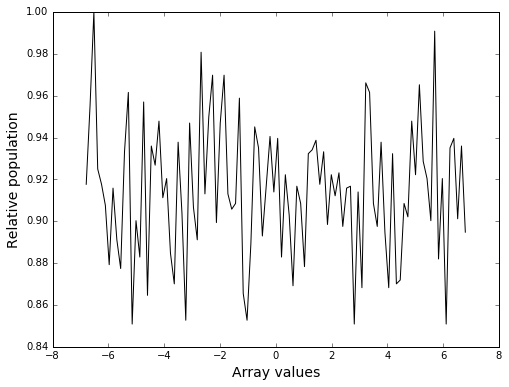

In [11]:
part = myBunch.get_local_particles()
part[:,4]
zvals = part[:,4]
utils.plot_distribution(zvals, 100)

##Run the simulation

In [10]:
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [11]:
opts.turns = 50
opts.checkpointperiod = 5
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

##Diagnostics

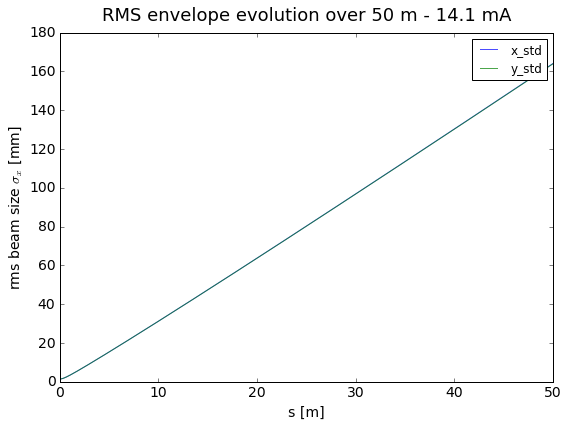

In [14]:
from base_diagnostics import diagplot2

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot2.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'b-', alpha=0.7, label = 'x_std') #plot x
ax.plot(xmaster,ystd*1.e3,'g-', alpha=0.7, label = 'y_std') #plot y
axtitle = "RMS envelope evolution over 50 m - 14.1 mA"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,50.0])
ax.legend()
sv_title = 'SC_test_envelope_10m_bunch.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

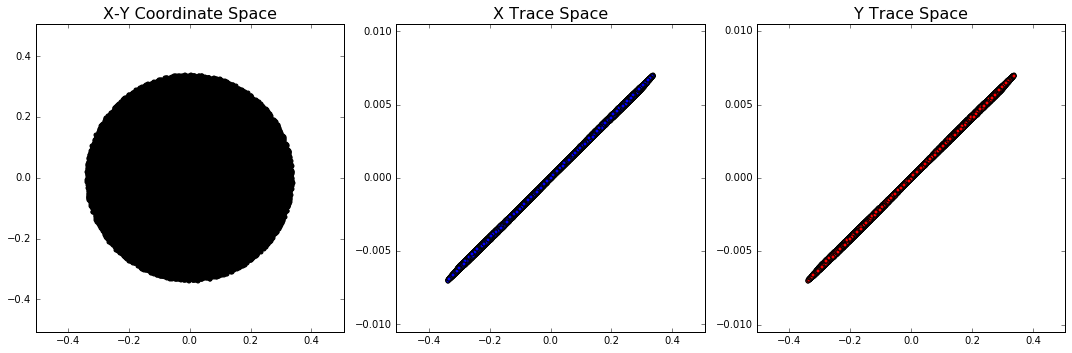

In [15]:
pltbunch.plot_bunch(myBunch)

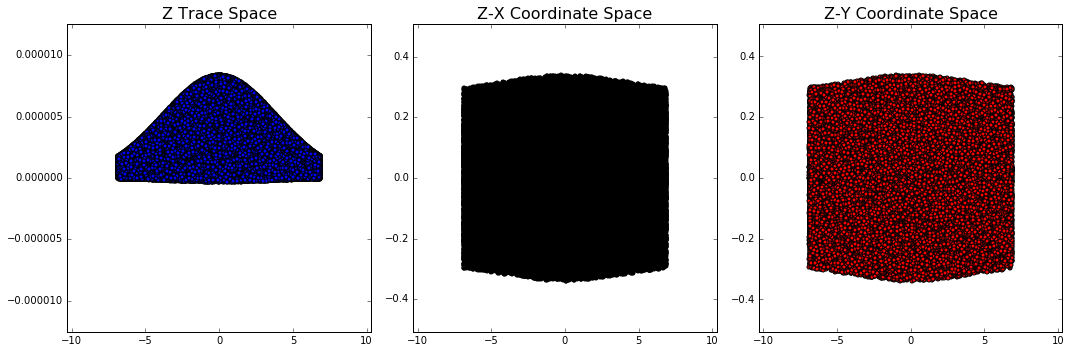

In [16]:
pltbunch.plot_long(myBunch)

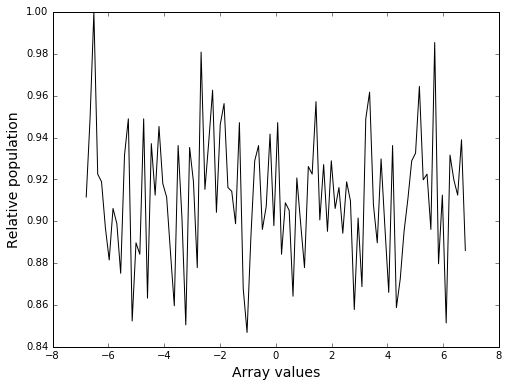

In [17]:
#Look at z distribution
part = myBunch.get_local_particles()
part[:,4]
zvals = part[:,4]
utils.plot_distribution(zvals, 100)

####Compare expansion against particle diagnostics

This provides a nice check, but I have noticed no inconsistencies outside of one occasion, which was fixed by a kernel restart. For the current simulation, the the particle values are only extracted every 10 m, so it only provides a rough check.

In [18]:
opts.relpath = opts.output_dir
#opts.relpath = 'SC_drift_test-2'
files = elliptic_sp.get_file_list(opts)
twiss = elliptic_sp.get_toy_twiss(opts)
lost = elliptic_sp.get_lost_particle_list(opts)

if len(lost) > 0:
    #we have lost particles
    opts.lost = lost #store these in opts.lost
    lost = True #make lost a simple flag


xrms_vals = []

#loop through all files and grab particles - calculate the RMS x value at each turn
for outfile in files:

    if lost:
        header, particles, lost_particles = elliptic_sp.get_particles(outfile, lost,opts.lost)
    else:
        header, particles = elliptic_sp.get_particles(outfile, lost)
    
    xrms = np.std(particles[:,0])
    
    xrms_vals.append(xrms)

zvals = (50./ (len(files)-1))*np.asarray(list(range(len(files)))) #construct s value parameters
xrms_vals = np.asarray(xrms_vals)*1.e3

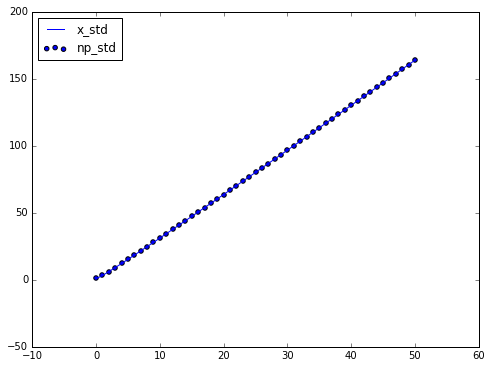

In [19]:
fig = plt.figure()
ax = fig.gca()
ax.plot(xmaster,xstd*1.e3, label = 'x_std')
ax.scatter(zvals,xrms_vals, label='np_std')
ax.legend(loc=2)

##Analytical Comparison

In [20]:
def calc_perveance(I,ref,cn=0):
    '''Calculate the perveance for a proton beam of a given current and particle energy.
    
    Arguments
        - I - current in A
        - ref - the reference particle for extracting beta and gamma
        
        - (optional) charge neutralization factor - default 0
    '''
    
    I0 = 3.13e7 #characteristic current
    
    beta = ref.get_beta()
    gamma = ref.get_gamma()
    
    return (I/I0)*(2/beta**3)*(1/gamma**3)

def calc_characteristic_current():
    '''Return characteristics current for proton beam'''
    return 4*np.pi*scipy.constants.epsilon_0*scipy.constants.m_p*(scipy.constants.c**3)/scipy.constants.e

In [21]:
#Introduce numerical integrators

#2nd Order RK - Ralston Method
def Ralston(r,z,h,f):
    k1 = h*f(r)
    return 0.25*k1 + 0.75*h*f(r+(2/3)*k1)

#4th Order Runge-Kutta
def RungeKutta4(r,z,h,f):
    k1 = f(r)
    k2 = f(r + (h/2)*k1)
    k3 = f(r + (h/2)*k2)
    k4 = f(r + h*k3)
    return h/6*(k1 + 2*k2 +2*k3 + k4)

#function here, which is a function of r and z
def rprime(K,emit,r0,rp0,rm):
    '''
    
    Returns the slope of the beam envelope (dr/dz) for a given value of emittance,rm, K, and initial conditions.
    
    This equation follows from Reisier.
    
    Arguments:
    
        - r - beam radius (or RMS)
        - K - perveance
        - emit - geometric emittance
        - r0 - initial envelope radius (or RMS)
        - rp0 - initial slope of envelope (or RMS)
        
    '''
    
    first = rp0**2 #first term
    second = (emit**2)*((1./r0**2)-(1./rm**2)) #second term
    third = 2*K* np.log(rm/r0) / 4
    
    return np.sqrt(first + second + third)

In [22]:
import math
from __future__ import division

def calculate_expansion(current, reference_paricle,r0,rp0,emit=emit,N=1000,zf=50.0):

    '''Evaluate the expansion of a KV beam envelope in a drift along z-axis, begining at z = 0.
    
    Arguments:
        - current - beam current in A
        - reference_particle - synergia object for bunch/lattice reference particle
        - r0 - initial envelope value (provide RMS for RMS expansion, a for envelope expansion, etc.)
        - rp0 - initial slope of envelope (must be non-zero, but calculation is not sensitive to small values)
        
        - (optional) emit - geometric emittance of beam - default 2.05721258396*1.e-6 (for 0.3 mm-mrad KV beam)
        - (optional) N - number of steps for integration - default 1000
        - (optional) zf - final z value (e.g. length of expansion) - default 50.0
        
    '''
    
    z0 = 0.0 #start
    ss = (zf-z0)/N #step size

    zpoints = np.linspace(0.0, zf, num=N) #define z values
    rpoints = [] #empty array for r values
    
    #calculate perveance
    Kp = calc_perveance(current, reference_particle)
    
    #x is r
    #z is t (what we step up)
    #f is our function describing the relationship between r and z
    f = lambda r: rprime(Kp,emit,r0,rprime0,r)

    r,z,dz = r0,z0,ss
    points = []
    while z < zf:
        points.append((z,r))
        z, r = z+dz, r + Ralston(r,z,dz,f) #incremement
        
    return points

In [23]:
#Calculate for two currents - 14 mA and for the schewed current value

current14 = 14*1.e-3
currentSkew = 14*1.e-3*opts.beta*3.3 #3.3658 mA
rprime0 = 1.0*(xstd[1]-xstd[0])/(xmaster[1]-xmaster[0])
r0 = xstd[0] #1.0*1.e-3 #initial envelope value
#emit = 4.10849449506e-06 #not used (hard coded into calculate_expansion) #gemit_x  #rms geometric emittance
points14 = calculate_expansion(current14, reference_particle, r0,rprime0)
pointsSkew = calculate_expansion(currentSkew, reference_particle, r0,rprime0)
points0 = calculate_expansion(0.0, reference_particle, r0,rprime0)
print emit

4.10849449506e-06


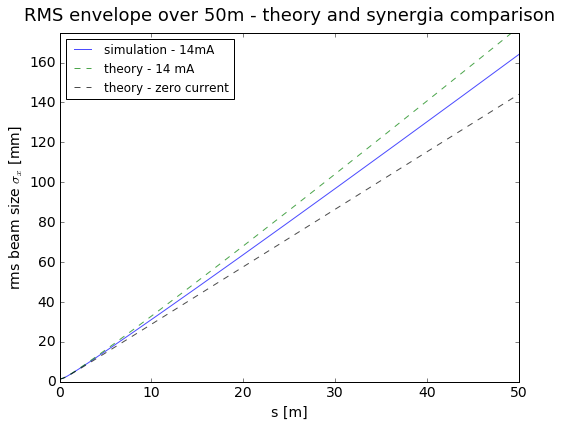

In [27]:
#Compare the results
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(xmaster,xstd*1.e3,'b-', alpha=0.7, label = 'simulation - 14mA') #plot x
ax.plot([p[0] for p in points14], [p[1]*1.e3 for p in points14],'g--',alpha=0.7, label = 'theory - 14 mA')
#ax.plot([p[0] for p in pointsSkew], [p[1]*1.e3 for p in pointsSkew],'r--',alpha=0.7, label = 'theory - 3.37 mA')
ax.plot([p[0] for p in points0], [p[1]*1.e3 for p in points0],'k--',alpha=0.7, label = 'theory - zero current')
axtitle = "RMS envelope over 50m - theory and synergia comparison"
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,50.0])
ax.set_ylim([0,175.0])
ax.legend(loc = 2)
#sv_title = 'BE_KV_p9.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

According to the envelope equation, the expansion follows the rate predicted by a beam of 3.36 mA, not a 14 mA beam.